# Remarks



# Imports

In [ ]:
import collections
from copy import deepcopy
import csv
import json
import math
import matplotlib.pyplot as plt
import os.path
%matplotlib inline
from numbers import Number
import numpy as np
from numpy.random import randint
from numpy.random import choice
import pandas as pd
from scipy.spatial.transform import Rotation
import textwrap
from typing import Callable, Optional, List # Union

from google.colab import drive
drive.mount('/content/drive/', force_remount = True)
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/HexaGenUtils')

# %load_ext autoreload
# %autoreload 2
import plot_utils2 as pu

data_dir_name = '/content/drive/MyDrive/Colab Notebooks/Data/'
abspar_dir_name = '/content/drive/MyDrive/Colab Notebooks/AbsPar/'

Mounted at /content/drive/


# Commands Execution

Template for creating a board and adding drawings on it:

```
# 1. initialization:
COMMANDS = Commands() # create a Commands instance that will collect the commands
BOARD = Board(HEIGHT, WIDTH) # create a Board instance

2. writing commands:
args = {} 
# optional: define a set of arguments
# this is necessary only when using 'get_action' to repeat and action
def action(args): 
  # fill this to draw on the board!
  pass
COMMANDS.add('1', action, args) # add (action, args) pair to the list of commands

# you may continue adding more commands to COMMANDS

3. executing commands:
executed_board = COMMANDS.executor()[-1] # execute the commands
pu.plot_boards(executed_board) # plot the final board
```
Use 'create_empty_template()' to pring a new empty template


In [ ]:
'''
Class 'Commands' handles a list of commands (action-arguments pair)

external methods:
- 'add': used to add a command to the list
- 'execute': executes the list and returns a list of colored_boards
- 'get_action': repeat a previous action (with different aruments)
- 'get_tiles' / 'get_shapes' / 'get_lines' / 'get_circles' / 'get_triangles': access previously drawn objects

Note: We want to change the implementation so this mechanism will be transparent to the user
'''

class Commands:
  def __init__(self):
    self._commands = []
    self._size = 0
    self._current_ind = None
    self._current = None

  class _SingleCommand:
    def __init__(self, name, action, args):
      self.name = name
      self.action = action
      self.args = args
      self.executed = False
      self.drawn = {'tiles':[], 'shapes':[], 'lines':[], 'circles':[], 'triangles':[]}

    def add_missing_args(original_args, additional_args):
      for k in additional_args.keys():
        if k not in original_args.keys():
          original_args[k] = additional_args[k]

  def _update_drawn(self, object, kind):
    # print(f'adding object of type {kind}')
    # object._show()
    self._current.drawn[kind].append(object)

  def _names(self):
    return [_.name for _ in self._commands]

  def __iter__(self):
    self.n = 0
    return self

  def __next__(self):
    if self.n < self._size:
      result = self._commands[self.n]
      self.n += 1
      return result
    else:
      raise StopIteration

  def _by_name(self, name):
    return self._commands[self._names().index(name)]

  def _by_names(self, names):
    return [_ for _ in self._commands if _.name in names]

  def _get_shapes(self, command_names, kind):
    if command_names == 'all':
      selected_commands = self._commands[:COMMANDS._current_ind + 1]
    else:
      assert isinstance(command_names, list), f'command_names should be a list of strings'
      selected_commands = self._by_names(command_names)
    return [tile for _ in selected_commands for tile in _.drawn[kind]]

  def _get_action(self, command_names):
    prev_commands = self._by_names(command_names)
    def f(args):
      for prev_command in prev_commands:
        args_ = deepcopy(self._current.args['original_args'])
        Commands._SingleCommand.add_missing_args(args_, prev_command.args)    
        args_['original'] = deepcopy(args_)
        prev_command.action(args_)
    return f     
  
  def execute(self, print_board = False):  
    colored_boards = []
    for ind, command in enumerate(self):
      self._current = command
      self._current_ind = ind
      command.action(command.args)
      command.executed = True
      colored_boards.append(BOARD._get('color'))
      if print_board:
        print(f'\n# {command.name}: {colored_boards[-1]}')
    return colored_boards

  def add(self, command_name, action, args):
    assert command_name not in self._names(), f'name {command_name} already in use'
    new_command = Commands._SingleCommand(command_name, action, args)
    new_command.args['original_args'] = deepcopy(args)
    if self._size > 0:
      Commands._SingleCommand.add_missing_args(new_command.args, self._commands[-1].args)
    self._commands.append(new_command)
    self._size += 1

  # get functions

  def get_action(self, command_names):
    assert isinstance(command_names, list), f'command_names should be a list of strings'
    return self._get_action(command_names)

  def get_tiles(self, command_names):
    return self._get_shapes(command_names, 'tiles')

  def get_shapes(self, command_names):
    return self._get_shapes(command_names, 'shapes')

  def get_circles(self, command_names):
    return self._get_shapes(command_names, 'circles')

  def get_lines(self, command_names):
    return self._get_shapes(command_names, 'lines') 

  def get_triangles(self, command_names):
    return self._get_shapes(command_names, 'triangels')    

# Abstraction Formalism

In [ ]:
# set constants

HEIGHT = 10 # number of lines
WIDTH = 18 # number of rows
COLORS = ['white', 'black', 'yellow', 'green', 'red', 'blue', 'purple', 'orange']
NUM_COLORS = len(COLORS)
DIRECTIONS = {'up': [0, -1, 1], 'down': [0, 1, -1], 'down_right': [1, 0, -1], 'up_left': [-1, 0, 1], 'down_left': [-1, 1, 0], 'up_right': [1, -1, 0]}
# H = 10
# W = 18

CoordinateIndices = collections.namedtuple('coordinates', ['q', 'r', 's', 'column', 'row', 'lind', 'color',
                                                           'cube', 'offset',
                                                           'up', 'down', 'down_right', 'up_left', 'down_left', 'up_right'])
INDICES = CoordinateIndices(0, 1, 2, 3, 4, 5, 6, 
                                       np.array([0, 1, 2]), np.array([3, 4]),
                                       0, 0, 1, 1, 2, 2)

def color_to_num(color):
  if isinstance(color, Number):
    return color
  else:
    return COLORS.index(color)

def cyclic_permutation(ls, k):
  # if k >= 0, element 0 becomes element k
  # if k < 0, element (-k) becomes element 0
  return ls[-k:] + ls[:-k]


In [ ]:
'''
_Vec represents a vector on an infinite hexagonally tiled plane
it shouldn't be used externally
it is used by other classes in operations like shifting tiles and creating polygons
'''

class _Vec:
  def __init__(self, *args):
    if isinstance(args[0], str):
      # _Vec is given as a direction name, e.g. 'up_right'
      q, r, s = DIRECTIONS[args[0]]
    elif len(args) == 3:
      # _Vec is given as cube [q, r, s]
      q, r, s = args
    elif len(args) == 2:
      # _Vec is given as offset [column_diff, row_diff]
      column, row = args
      q = column
      r = row - (q - (q % 2)) // 2
      s = -q - r      
    if abs(q + r + s) > 0.00001:
      raise Exception(f'cube coordinates {[q, r, s]} don\'t sum up to 0')
    self._q = q
    self._r = r
    self._s = - q - r
    self._cube = [q, r, s]

  def _show(self):
    print(f'{self.__class__.__name__} instance: cube = {self._cube}')

  def _has_direction(self):
    # if q*r*s=0 means that vec is proportional to a direction vec
    return 1 - self._q * self._r * self._s

  def _normalize(self):
    if self._has_direction():
      norm = self._norm()
      direction_cube = [x // norm for x in self._cube]
      return _Vec(*direction_cube)
    print(f'vec {self._cube} is not a direction vector')

  def _direction_str(self):
    # returns a string describing the direction of the vector
    if self._has_direction():
      return list(DIRECTIONS.keys())[list(DIRECTIONS.values()).index(self._normalize()._cube)]
    print(f'vec {self._cube} is not a direction vector')

  def __add__(self, other):
    new_cube = [_ for _ in [x + y for x,y in zip(self._cube, other._cube)]]
    return _Vec(*new_cube)
  
  def __sub__(self, other):
    new_cube = [_ for _ in [x - y for x,y in zip(self._cube, other._cube)]]
    return _Vec(*new_cube)

  def _scale(self, k):
    return _Vec(*[k * _ for _ in self._cube])

  def _norm(self):
    return np.sum([np.abs(_) for _ in self._cube]) / 2

  def _round(self):
    int_cube = [np.round(_) for _ in self._cube]
    diff = [abs(x - y) for x, y in zip(int_cube, self._cube)]
    ind = np.argmax(diff)
    int_cube[ind] = - (np.sum(int_cube)) + int_cube[ind]
    int_cube = [int(_) for _ in int_cube]
    return _Vec(*int_cube)

In [ ]:
'''
_Tile represents a tile on the board
it shouldn't be used externally
'''

class _Tile:

  def __init__(self, lind, q, r, s, column, row):
    if lind is not None:
      lind = int(lind)
    q, r, s = int(q), int(r), int(s)
    column, row = int(column), int(row)
    if q + r + s != 0:
      raise Exception(f'cube coordinates {[q, r, s]} don\'t sum up to 0')    
    self._q = q
    self._r = r
    self._s = s
    self._cube = [q, r, s]
    self.column = column
    self.row = row
    self.offset = [column, row]
    self._lind = lind
    self.color = 0

  def _show(self):
    print(f'{self.__class__.__name__} instance: lind = {self._lind}, cube = {self._cube}, offset = {self.offset}, color = {self.color}')

  def _on_board(self):
    '''
    return True if the tile is on board
    '''
    return self._lind is not None

  def _diff(self, other):
    return _Vec(*[int(_) for _ in [y - x for x,y in zip(self._cube, other._cube)]])

  def _shift(self, *args):
    vec = args[0]
    if not isinstance(vec, _Vec):
      vec = _Vec(args)
    new_cube = [int(_) for _ in [x + y for x, y in zip(self._cube, vec._cube)]]
    return Tile(cube = new_cube)

  def _copy_paste(self, vec, color = None):
    new_tile = self._shift(vec)
    # if self._on_board():    
    #   color = self.color if color is None else color
    #   new_tile.draw(color)
    color = self.color if color is None else color
    new_tile.draw(color)
    return new_tile

  def _reflect(self, axis_line = None, column = None, axis_direction = None, tile_on_axis = None):
    if axis_direction == 'horizontal':
      direction_vec = _Vec(2, -1, -1)
    else:
      if axis_line is not None:
        direction_vec = axis_line._direction_vec
        tile_on_axis = axis_line._tiles()[0]
      else:
        if axis_direction == 'vertical' or column is not None: 
          axis_direction = 'up'
        direction_vec = _Vec(axis_direction)

    v_direction = np.array(direction_vec._cube)
    v_direction = v_direction / np.linalg.norm(v_direction)
    v_direction_reciprocal = np.array([direction_vec._r - direction_vec._s, direction_vec._s - direction_vec._q, direction_vec._q - direction_vec._r])
    v_direction_reciprocal = v_direction_reciprocal / np.linalg.norm(v_direction_reciprocal)
    if column is not None:
      # we assume if axis_value is given it represents a column number 
      column = column % (BOARD._W + 1)
      axis_value = column - 1
      # cube = [0, 0, 0]
      # ind = direction_vec._cube.index(0)
      # cube[ind] = axis_value
      # cube[(ind + 1) % 3] = -axis_value
      # cube[(ind + 2) % 3] = 0
      ind = direction_vec._cube.index(0)
      cube = cyclic_permutation([axis_value, -axis_value, 0], ind)
      v_on_axis = np.array(cube)
    else: 
      v_on_axis = np.array(tile_on_axis._cube)
    v_self = np.array(self._cube)
    v_diff = v_self - v_on_axis
    val_reciprocal = v_diff.dot(v_direction_reciprocal)
    reflect_vec = _Vec(*list(-2 * val_reciprocal * v_direction_reciprocal))._round()
    new_tile = self._shift(reflect_vec)
    color = self.color
    new_tile.draw(color)
    return new_tile

  def _rotate(self, rotation, center):
    v_self = np.array(self._cube)  
    v_center = np.array(center._cube)
    rotvec = np.ones(3) / np.sqrt(3) * (rotation * np.pi / 3)
    R = Rotation.from_rotvec(rotvec).as_matrix()
    v_new = np.matmul(v_self - v_center, R) + v_center
    new_tile_vec = _Vec(*list(v_new))._round()
    new_tile = Tile(cube = new_tile_vec._cube)
    color = self.color
    new_tile.draw(color)
    return new_tile

  def draw(self, color):
    '''
    draw a single tile with color 'color'
    '''
    BOARD._draw(self, color)
    # BOARD.colors[self._lind] = color_to_num(color)
    # self.color = color
    # commands._update_drawn(self, 'tiles')
    return self

  def neighbor(self, direction):
    '''
    return the neighbor of self in the given direction
    for external use, direction is direction-name (str)
    '''
    if not isinstance(direction, _Vec):
      vec = _Vec(direction)
    return self._shift(vec)

  def neighbors(self, criterion = 'all'):
    '''
    return all the neighbors of self
    '''
    tiles = []
    for direction_cube in DIRECTIONS.values():
      new_tile = self._shift(_Vec(*direction_cube))
      if new_tile._on_board():
        tiles.append(new_tile)
    if criterion == 'all':
      return Shape(tiles)
    if criterion == 'blank':
      return Shape(tiles) * BOARD.filter('color', '==', 'white')

In [ ]:
'''
Note: 'Tile' is implemented as a subclass of '_Tile' for the following reason:
when a new Board instance is created, it creates all the _Tile objects of the board
when a user calls 'Tile(3, 4)', we don't want a new object to be created
rather, we wish to return the existing corresponding '_Tile' instance
this is implemented using the subclass 'Tile(_Tile)' with an overriding '__new__' method
actually, initiating 'Tile' always returns a '_Tile' object!

Note: it is possible that 'Tile' will return a new tile that is outside the board
this is legal, and is done for the following reason:
we want a call like "Tile(1,1).neighbor('up').neighbor('up')" to be legal and to return a proper '_Tile' object
(this returns the upper neighbor of the upper neighbor of 'Tile(1,1)', which is outside the board)
'''

class Tile(_Tile):
  def __new__(cls, column = None, row = None, lind = None, cube = None, **kwargs):
    if (column is not None) and (row is not None):
      # Tile is given as offset = [column, row]
      # deal with negative row/column
      column = column % (BOARD._W + 1)
      row = row % (BOARD._H + 1)
      # compute cube coordinates. offset [1, 1] is cube [0, 0, 0]
      q = column - 1
      r = row - 1 - (q - (q % 2)) // 2
      s = -q - r
    elif cube is not None:
      # Tile is given as cube = [q, r, s]
      q, r, s = cube
      if q + r + s != 0:
        raise Exception(f'cube coordinates {[q, r, s]} don\'t sum up to 0')
      column = q + 1
      row = r + (q - (q % 2)) // 2 + 1            
    if column >= 1 and row >= 1 and column <= BOARD._W and row <= BOARD._H:
      lind = int((row - 1) * BOARD._W + (column - 1))
    else:
      # tile is not on board, so it has no linear index
      lind = None

    if lind is not None:
      return BOARD._tiles[lind]
    else:
      return _Tile(lind, q, r, s, column, row)

  def __init__(self):
    pass

  def _show(self):
    print(f'{self.__class__.__name__} instance: lind = {self._lind}, cube = {self._cube}, offset = {self.offset}, color = {self.color}')

In [ ]:
'''
Board represents the entire board
it contains a list of all the '_Tile' objects that are on the board
the user should always start with the command 'BOARD = Board()'
'BOARD' is used as a global variable and is used by other classes

external methods (all return a 'Shape' instance)
- 'board()': returns the entire board as Shape object
- 'perimeter()': returns the board's perimeter as Shape object
- 'filter(...)': filter the board by various properties (see more information under 'Shape')
'''

class Board:
  def __init__(self, H, W):
    self._H = HEIGHT
    self._W = WIDTH

    tiles = [None] * self._H * self._W    
    C = np.zeros([self._H * self._W, 7], dtype = int)
    lind = 0
    for row in range(1, self._H + 1):
      for column in range(1, self._W + 1):
        q = column - 1
        r = row - 1 - (q - (q % 2)) // 2
        s = -q - r      
        C[lind, INDICES.q] = q
        C[lind, INDICES.r] = r
        C[lind, INDICES.s] = s
        C[lind, INDICES.column] = column
        C[lind, INDICES.row] = row
        C[lind, INDICES.lind] = lind
        C[lind, INDICES.color] = 0
        tiles[lind] = _Tile(lind, q, r, s, column, row)
        lind += 1

    self._tiles = tiles
    self._table = C

  def _show(self):
    print(f'{self.__class__.__name__} instance: height = {self._H}, width = {self._W}')
    print(f'table is: \n{self._table}')

  def _get(self, attr, linds = None):
    if linds is None:
      linds = [_ for _ in range(self._H * self._W)]
    return self._table[np.array(linds), getattr(INDICES, attr)]

  def _draw(self, tile, color):
    if tile._on_board():
      color = color_to_num(color)
      tile.color = color
      self._table[tile._lind, getattr(INDICES, 'color')] = color
      COMMANDS._update_drawn(tile, 'tiles')     
    else: 
      print(f'tile {tile.offset} is not on board')

  def board(self):
    return Shape(list(np.arange(self._H * self._W)), True)

  def perimeter(self):
    '''
    returns the perimeter as shape
    '''
    left_right = set(np.argwhere(self._get('column') == np.min(self._get('column'))).flatten()) | set(np.argwhere(self._get('column') == np.max(self._get('column'))).flatten())
    top_bottom = set(np.argwhere(self._get('row') == np.min(self._get('row'))).flatten()) | set(np.argwhere(self._get('row') == np.max(self._get('row'))).flatten())
    return Shape(list(left_right | top_bottom), True)

  def filter(self, property_: str, relation: str, value, divisor: Optional[int] = None):
    return Shape(self._tiles).filter(property_, relation, value, divisor)

In [ ]:
'''
Shape represents a set of tiles on the board

external methods:

return Boolean:
- 'is_empty()': return True iff self is empty
- 'overlaps(other (Shape))': return True iff self and other don't overlap

return Shape:
'shift'
'select'
'neighbors'
'filter'
'polygon'

'select(self, criterion)'
    exterior: tiles that are not part of the shape, and can be connected to the board's perimeter
    interior: tiles that are not part of the shape and that are not part of the exterior
    external: tiles that are part of the shape and touch the exterior
    internal: tiles that are part of the shape and touch the interior
    above: tiles that are above the shape
    below: tiles that are below the shape
    vertices: e.g. vertices of a triangle. tiles that are part of the shape, are external, and have 2 neighbors that are external
    edges: e.g. the start and end of a line. tiles that are part of the shape, are external, and have 2 neighbors that are external

'extereme(self, criterion)'
      'right': the rightmost tiles of the shape
      'left': the leftmost tiles of the shape
      for any direction, we can get the most extreme tiles in this direction
      e.g. 'up' will give the upmost tiles of the shape

'neighbors(self)'
'neighbors(self, criterion)'

    selecting a subset of the shape's neighbors
    criterion:
      'all': all neighboring tiles
      'right': neighbors from the right (must touch at least two tiles from the shape)
      'left': neighbors from the left (must touch at least two tiles from the shape)
      'external': neighbors that belong to the exterior
      'internal': neighbors that belong to the interior
      for any direction, we can get the neighbors on this direction
      e.g. 'up' will give the neighbors from above      
'blank': white neighbors

'filter(self, property_, relation, value)'
'filter(self, property_, relation, value, divisor)'

'polygon(*tiles)'
'polygon(tiles)'
'polygon(shape)'



draw something on the board (and also return Shape):
'draw(self, color)': draw self in the given color

'copy_paste(self, direction, spacing)'
'copy_paste(self, direction, spacing, reference_shape)'

'grid(self, direction, spacing)'
'grid(self, direction, spacing, length)'

'reflect(self, axis_line)'
'reflect(self, axis_direction, tile_on_axis)'
'reflect(self, column)'

'recolor(self, color_map)'

'center(self)'


Note: 'Shape' actually holds a list of tile identifiers (and not a set)
the order of the tiles might be meaningful, for example when we create a line, 
the tiles are ordered from start to end

Note: 'Shape' is an iterator. iterating over a shape returns tiles
'''

"\nShape represents a set of tiles on the board\n\nexternal methods:\n\nreturn Boolean:\n- 'is_empty()': return True iff self is empty\n- 'overlaps(other (Shape))': return True iff self and other don't overlap\n\nreturn Shape:\n'shift'\n'select'\n'neighbors'\n'filter'\n'polygon'\n\n'select(self, criterion)'\n    exterior: tiles that are not part of the shape, and can be connected to the board's perimeter\n    interior: tiles that are not part of the shape and that are not part of the exterior\n    external: tiles that are part of the shape and touch the exterior\n    internal: tiles that are part of the shape and touch the interior\n    above: tiles that are above the shape\n    below: tiles that are below the shape\n    vertices: e.g. vertices of a triangle. tiles that are part of the shape, are external, and have 2 neighbors that are external\n    edges: e.g. the start and end of a line. tiles that are part of the shape, are external, and have 2 neighbors that are external\n\n'extere

In [ ]:
'''
Shape represents a set of tiles on the board

external methods:

return Boolean:
- 'is_empty()': return True iff self is empty
- 'overlaps(other (Shape))': return True iff self and other don't overlap

return Shape:
'shift'
'select'
'neighbors'
'filter'
'polygon'

draw something on the board (and also return Shape):
'draw'
'copy_paste'
'grid'
'reflect'
'recolor'

Note: 'Shape' actually holds a list of tile identifiers (and not a set)
the order of the tiles might be meaningful, for example when we create a line, 
the tiles are ordered from start to end

Note: 'Shape' is an iterator. iterating over a shape returns tiles
'''

class Shape:
  def __init__(self, tiles, from_list_of_linds = False):
    if isinstance(tiles, Shape):
      linds = tiles._linds
    elif from_list_of_linds:
      linds = tiles
    else:
      linds = [_._lind for _ in tiles]
    unique_linds = []
    unique_inds = []
    for i, lind in enumerate(linds):
      if lind not in unique_linds and lind is not None:
        unique_linds.append(lind)
        unique_inds.append(i)
    self._linds = unique_linds
    # self._tiles = [tiles[_] for _ in unique_inds]
    self._size = len(self._linds)

  def _show(self):
    print(f'{self.__class__.__name__} instance: linds = {self._linds}, size = {self._size}')

  def __iter__(self):
    self.n = 0
    return self

  def __next__(self):
    if self.n < self._size:
      result = BOARD._tiles[self._linds[self.n]]
      self.n += 1
      return result
    else:
      raise StopIteration

  def __getitem__(self, item):
    return Tile(self.linds[item])

  def __add__(self, other):
    linds = list(set(self._linds) | set(other._linds))
    return Shape(linds, True)

  def __mul__(self, other):
    linds = list(set(self._linds) & set(other._linds))
    return Shape(linds, True)

  def __sub__(self, other):
    linds = list(set(self._linds).difference(set(other._linds)))
    return Shape(linds, True)

  def _tiles(self):
    return [BOARD._tiles[_] for _ in self._linds]

  def _compute_shift_from_spacing(self, direction, spacing, reference_shape = None):
    if reference_shape is None:
      reference_shape = self
      # initial_shift = _Vec(0, 0, 0)
    # else:
    vec_diff = reference_shape._center_of_mass() - self._center_of_mass()
    initial_shift = vec_diff._round()
    if direction == 'left':
      shift = _Vec(-2, 0)
      spacing -= spacing % 2
    elif direction == 'right':
      shift = _Vec(2, 0)
      spacing -= spacing % 2
    else:
      shift = _Vec(direction)
    step_size = shift._norm()
    new_shape = deepcopy(self).shift(initial_shift)
    steps = 0
    count_space = 0
    while new_shape.overlaps(reference_shape) or count_space < spacing:
      if not new_shape.overlaps(reference_shape):
        count_space += step_size
      new_shape = new_shape.shift(shift)
      steps += 1
    total_shift = shift._scale(steps) + initial_shift
    return total_shift

  def _shifted_shape_fits_board_completely(self, shift):
    return self.shift(shift)._size == self._size
  
  def _center_of_mass(self):
    cubes_arr = np.array([_._cube for _ in self])
    return _Vec(*np.mean(cubes_arr, axis = 0))

  def _get(self, attr):
    return BOARD._get(attr, self._linds)

  def is_empty(self):
    return self._size == 0

  def overlaps(self, S):
    return not (self*S).is_empty()

  def draw(self, color):
    for tile in self:
      tile.draw(color)
    COMMANDS._update_drawn(self, 'shapes')
    return self

  def copy_paste(self, shift_direction = None, spacing = None, reference_shape = None, shift = None):
    '''
    draw a copy of the object 'tiles' in a new location
    '''

    if shift is None:
      shift = self._compute_shift_from_spacing(shift_direction, spacing, reference_shape)

    new_tiles = []
    for tile in self:
      tile._copy_paste(shift)
      new_tiles.append(tile._shift(shift))
    new_shape = Shape(new_tiles)
    COMMANDS._update_drawn(new_shape, 'shapes')
    return new_shape

  def grid(self, shift_direction, spacing, num_copies = None):
    shift = self._compute_shift_from_spacing(shift_direction, spacing, None)

    new_shape = self
    if num_copies is not None:
      for k in range(1, num_copies + 1):
        new_shape += self.copy_paste(shift = shift._scale(k))
    else:
      k = 1
      while self._shifted_shape_fits_board_completely(shift._scale(k)):
        new_shape += self.copy_paste(shift = shift._scale(k))
        k += 1
    return new_shape

  def reflect(self, axis_line = None, column = None, axis_direction = None, tile_on_axis = None):
    new_tiles = []
    for tile in self:
      new_tiles.append(tile._reflect(axis_line = axis_line, column = column, axis_direction = axis_direction, tile_on_axis = tile_on_axis))
    new_shape = Shape(new_tiles)
    COMMANDS._update_drawn(new_shape, 'shapes')
    return new_shape

  def rotate(self, rotation, center_tile):
    new_tiles = []
    for tile in self:
      new_tiles.append(tile._rotate(rotation = rotation, center = center_tile))
    new_shape = Shape(new_tiles)
    COMMANDS._update_drawn(new_shape, 'shapes')
    return new_shape

  def recolor(self, color_map):
    '''
    re-color each tile in the shape
    color_map describes a mapping from colors to colors, e.g. {'red': 'blue', 'green': 'black'}
    '''
    for tile in self:
      if tile._on_board():
        tile.draw(color_map[COLORS[tile.color]])
    COMMANDS._update_drawn(self, 'shapes')
    return self

  def shift(self, V):
    return Shape([_._shift(V) for _ in self])

  def select(self, criterion): 
    '''
    exterior: tiles that are not part of the shape, and can be connected to the board's perimeter
    interior: tiles that are not part of the shape and that are not part of the exterior
    external: tiles that are part of the shape and touch the exterior
    internal: tiles that are part of the shape and touch the interior
    above: tiles that are above the shape
    below: tiles that are below the shape
    vertices: e.g. vertices of a triangle
    edges: e.g. the start and end of a line
    '''
    if criterion == 'exterior':
      S_ext = BOARD.perimeter() - self 
      while True:
        S_ext_neighbors_not_in_self = S_ext.neighbors('all') - self
        # stop if S_ext didn't grow in the last iteration
        if S_ext_neighbors_not_in_self._size == 0:
          break
        else:
          S_ext += S_ext_neighbors_not_in_self
      return S_ext  
    if criterion == 'interior':
      return (BOARD.board() - self) - self.select('exterior')
    if criterion == 'external':
      return self.select('exterior').neighbors('all') * self
    if criterion == 'internal':
      return self - self.select('external')
    if criterion == 'above':
      board_columns = BOARD._get('column')
      S = Shape([])
      for column in np.unique(self._get('column')):
        row = min([_.row for _ in self if _.column == column])
        S += BOARD.filter('column', '==', column) * BOARD.filter('row', '<', row)
      return S
    if criterion == 'below':
      board_columns = BOARD._get('column')
      S = Shape([])
      for column in np.unique(self._get('column')):
        row = max([_.row for _ in self if _.column == column])
        S += BOARD.filter('column', '==', column) * BOARD.filter('row', '>', row)
      return S
    if criterion == 'vertices':
      vertices = []
      ext = self.select('external')
      for tile in ext:
        neighbors = (tile.neighbors() * ext)._tiles()
        if len(neighbors) == 2:
          v0 = tile._diff(neighbors[0])
          v1 = tile._diff(neighbors[1])
          if (v0 + v1)._norm() > 0.0001:
            vertices.append(tile)
      return Shape(vertices)
    if criterion == 'edges':
      vertices = []
      ext = self.select('external')
      for tile in ext:
        neighbors = (tile.neighbors() * ext)._tiles()
        if len(neighbors) == 1:
          vertices.append(tile)
      return Shape(vertices)

  def extreme(self, criterion):
    ''' 
    selecting a subset of extreme tiles from the shape
    criterion:
      'right': the rightmost tiles of the shape
      'left': the leftmost tiles of the shape
      for any direction, we can get the most extreme tiles in this direction
      e.g. 'up' will give the upmost tiles of the shape
    '''
    # shape_rows = self._get('row')
    if criterion == 'right':
      shape_columns = self._get('column')
      rightmost_column = np.amax(shape_columns)
      return Shape([_ for _ in self if _.column == rightmost_column])
    if criterion == 'left':
      shape_columns = self._get('column')
      leftmost_column = np.amin(shape_columns)
      return Shape([_ for _ in self if _.column == leftmost_column])
    if criterion in DIRECTIONS:
      direction_cube = DIRECTIONS[criterion]
      direction_ind = direction_cube.index(0)
      next_ind = (direction_ind + 1) % 3
      next_grows = (direction_cube[next_ind] == 1)
      direction_str = ['q', 'r', 's'][direction_ind]
      next_str = ['q', 'r', 's'][direction_ind]
      shape_lines = self._get(direction_str)
      tiles = []
      for val in np.unique(shape_lines):
        tiles_with_val = [_ for _ in self if _._cube[direction_ind] == val]
        if next_grows:
          tiles.append(tiles_with_val[np.argmax([_._cube[next_ind] for _ in tiles_with_val])])
        else:
          tiles.append(tiles_with_val[np.argmin([_._cube[next_ind] for _ in tiles_with_val])])
      return Shape(tiles)

  def neighbors(self, criterion = 'all'):
    '''
    selecting a subset of the shape's neighbors
    criterion:
      'all': all neighboring tiles
      'right': neighbors from the right (must touch at least two tiles from the shape)
      'left': neighbors from the left (must touch at least two tiles from the shape)
      'external': neighbors that belong to the exterior
      'internal': neighbors that belong to the interior
      for any direction, we can get the neighbors on this direction
      e.g. 'up' will give the neighbors from above 
      'blank': white neighbors     
    '''
    if criterion == 'all':
      return Shape([neighbor_tile for tile in self for neighbor_tile in tile.neighbors()]) - self
    if criterion == 'right':
      rightmost_tiles = self.extreme('right')
      down_right = Shape([_.neighbor('down_right') for _ in rightmost_tiles])
      up_right = Shape([_.neighbor('up_right') for _ in rightmost_tiles])
      return down_right * up_right
    if criterion == 'left':
      leftmost_tiles = self.extreme('left')
      down_left = Shape([_.neighbor('down_left') for _ in leftmost_tiles])
      up_left = Shape([_.neighbor('up_left') for _ in leftmost_tiles])
      return down_left * up_left
    if criterion in DIRECTIONS:
      return Shape([_.neighbor(criterion) for _ in self]) - self
    # if criterion == 'below':
    #   return Shape([_.neighbor('down') for _ in self.select('bottom')])
    if criterion == 'external':
      return self.neighbors('all') * self.select('exterior')
    if criterion == 'internal':
      return self.neighbors('all') * self.select('interior')
    if criterion == 'blank':
      return BOARD.filter('color', '==', 'white') * self.neighbors()

  def filter(self, property_: str, relation: str, value, divisor: Optional[int] = None) -> List[Tile]:
      '''
      filter the board according to a property, relation and value
      e.g. filter by property 'column', relation '>=', and value '5'
      supported properties: 'color', 'column', 'row', direction names
      supported relation: '==', '>', '<', '>=', '<=', 'above', 'below', 'in', 'mod', 'is'
      argument 'divisor' is for using the relation 'mod' 
      for relation 'in', value should be a list
      '''
      vals = BOARD._get(property_, self._linds)

      if property_ == 'color':
        value = color_to_num(value)

      if relation == 'is':
        vals = vals % 2
        value = '0' if value == 'even' else '1'
        relation = '=='
      else:
        if property_ == 'column':
          if isinstance(value, list):
            value = [_ % (BOARD._W + 1) for _ in value]
          else:
            value = value % (BOARD._W + 1)
        if property_ == 'row':
          if isinstance(value, list):
            value = [_ % (BOARD._H + 1) for _ in value]
          else:
            value = value % (BOARD._H + 1)

      # if relation == 'below':
      #   if property_ in ['r', 'up_left', 'down_right']:
      #     relation = '>'
      #   else: 
      #     relation = '<'
      # elif relation == 'above':
      #   if property_ in ['r', 'up_left', 'down_right']:
      #     relation = '<'
      #   else: 
      #     relation = '>'
      
      if relation == 'mod':
        vals = vals % divisor
        value = value % divisor
        relation = '=='          

      return Shape([_ for _ in self._linds if eval(f'{vals[_]} {relation} {value}')], True)

  def polygon(*args):
    if isinstance(args[0], Shape):
      tiles = args[0].tiles()
    elif isinstance(args[0], List):
      tiles = args[0]
    else:
      tiles = args
    com = Shape(tiles)._center_of_mass()

    def angle(self, other):
      self_reciprocal = _Vec(*[self._r - self._s, self._s - self._q, self._q - self._r])
      v_self = np.array(self._cube)
      v_self_reciprocal = np.array(self_reciprocal._cube)
      v_other = np.array(other._cube)
      # print(n_self.dot(n_other)) / np.linalg.norm(self_reciprocal._cube)
      # print(n_self.dot(n_other))
      product = v_self.dot(v_other) / np.linalg.norm(v_self) / np.linalg.norm(v_other)
      product = min(product, 1.)
      product = max(product, -1.)
      angle = np.arccos(product)
      if v_self_reciprocal.dot(v_other) < 0:
        angle = 2 * np.pi - angle
      return angle

    vecs = [_Vec(*_._cube) - com for _ in tiles]
    angles = [angle(vecs[0], _) for _ in vecs]
    sorted_tiles = [tile for angle, tile in sorted(zip(angles, tiles))]
    polygon = Shape([])
    for i in range(len(sorted_tiles)):
      polygon += Line(start_tile = sorted_tiles[i], end_tile = sorted_tiles[(i + 1) % len(sorted_tiles)])

    return polygon

  def center(self):
    return Tile(cube = self._center_of_mass()._round())

In [ ]:
class Line(Shape):
  def __init__(self, start_tile: Tile, end_tile: Optional[Tile] = None, direction: str = None, length: int = None, 
              end_tiles: Shape = Shape([]), include_start_tile: bool = True, include_end_tile: bool = True):
    '''
    create a straight line
    start_line: beginning of line
    color: color of line
    end_tile: end of line 
    length: length of line 
    direction: direction of line
    include_start_tile: if false, do not draw the tile 'start_tile'
    include_end: if false, do not draw the tile 'end_tile'
    end_tiles: continue the line until you reach a tile from this set
    '''
    if length is None:
      length = max(BOARD._H, BOARD._W)
    if end_tile is not None:
      v = start_tile._diff(end_tile)
      direction_vec = v._normalize()
      distance = v._norm()
      length = distance - 1 + 1 * include_start_tile + 1 * include_end_tile
    else:
      direction_vec = _Vec(direction)
    if not include_start_tile:
      start_tile = start_tile._shift(direction_vec)
    count = 0
    tiles = []
    tile = start_tile
    while count < length and tile._on_board() and tile._lind not in end_tiles._linds:
        tiles.append(tile)
        tile = tile._shift(direction_vec)
        count += 1
    super().__init__(tiles)
    self.start_tile = tiles[0]
    self.end_tile = tiles[-1]
    self.color = None
    self._direction_vec = direction_vec
    self.direction = direction_vec._direction_str()
    qrs_ind = direction_vec._cube.index(0)
    self.constant_value = tiles[0]._cube[qrs_ind]

  def _show(self):
    print(f'{self.__class__.__name__} instance: linds = {self._linds}, size = {self._size}, direction = {self.direction}, \
    start = {self._tiles()[0].offset}, end = {self._tiles()[-1].offset}, color = {self.color}')

  def draw(self, color):
    self.color = color
    super().draw(color)
    COMMANDS._update_drawn(self, 'lines')
    return self

In [ ]:
class Circle(Shape):
  def __init__(self, center_tile, radius = 1):
    tiles = []
    shifts = []
    for d0 in range(-radius, radius + 1):
        d1 = radius - d0 if d0 >= 0 else -radius - d0
        d2 = -d0 - d1
        d = [d0, d1, d2]
        for i in range(3):
          shift = _Vec(*[d[i % 3], d[(1 + i) % 3], d[(2 + i) % 3]])
          tiles.append(center_tile._shift(shift))
    super().__init__(tiles)
    self.center_tile =  center_tile
    self.color = None

  def _show(self):
    print(f'{self.__class__.__name__} instance: linds = {self._linds}, size = {self._size}, center = {self.center_tile.offset}, color = {self.color}')

  def draw(self, color):
    self.color = color
    super().draw(color)
    COMMANDS._update_drawn(self, 'circles')
    return self

In [ ]:
class Triangle(Shape):
  def __init__(self, start_tile, point, start_tile_type, side_length = 2):
    # point: 'left' / 'right', where does the triangle point
    # start_tile_type: 'side' / 'top' / 'bottom', where is 'start_tile' located w.r.t. the triangle
    tiles = []
    d_directions = {'left': ['up_right', 'down', 'up_left'], 'right': ['up_left', 'down', 'up_right']}
    types = ['side', 'top', 'bottom']
    tile = start_tile
    directions = cyclic_permutation(d_directions[point], -types.index(start_tile_type))
    for i_edge in range(3):
      for _ in range(side_length - 1):
        tiles.append(tile)
        tile = tile.neighbor(directions[i_edge])
    super().__init__(tiles)
    self.point = point
    self.side_length = side_length
    self.color = None

  def _show(self):
    print(f'{self.__class__.__name__} instance: linds = {self._linds}, size = {self._size}, center = {self.center_tile.offset}, color = {self.color}')

  def draw(self, color):
    self.color = color
    super().draw(color)
    COMMANDS._update_drawn(self, 'triangles')
    return self

# Abstraction Formalism 2

In [ ]:
# # 'control_flow': ['for_loop', 'while_loop', 'condition', 'var', 'range_']

# def for_loop(vals: list, func: Callable, zip_vals: bool = False) -> None:
#   '''
#   for loop:
#     apply the function 'func' on all the items in the list 'vals'
#     if zip_vals is True, zip together the lists inside the list 'vals'
#   '''
#   if not zip_vals:
#     for x in vals:
#       func(x)
#   else:
#     for x in zip(*vals):
#       func(*x)

# def while_loop(init, condition: Callable, func: Callable, update: Callable) -> None:
#   '''
#   while loop:
#     start with 'x=init'
#     in each step, if 'condition(x)' is True, run 'func(x)', and then update the value of 'x' using 'update(x)'
#   '''
#   x = init
#   while condition(x):
#     func(x)
#     x = update(x)

# def range_list(first: int, last: Optional[int] = None, length: Optional[int] = None, step: int = 1) -> List[int]:
#   '''
#   generate a list of integers
#   starting at 'first' and use step size 'step'
#   if 'last' is given, continue until you reach 'last' (don't pass it)
#   if 'length' is given, continue until you have 'length' numbers in your list
#   '''  
#   ls = [first]
#   if last is None:
#     count = 1
#     while count < length:
#       ls.append(ls[-1]+step)
#       count+=1
#   else:
#     if step > 0:
#       while ls[-1]+step <= last:
#         ls.append(ls[-1] + step)
#     elif step < 0:
#       while ls[-1]+step >= last:
#         ls.append(ls[-1] + step)
#   return ls

In [ ]:
# # filtering functions


# class Alternator:
#   def __init__(self, values):
#     self.values = values
#     self.current_alt_ind = 0

#   def get_value(self, alternate):
#     val = self.values[self._current_alt_ind]
#     if alternate: self._current_alt_ind = (self._current_alt_ind + 1) % len(self.values)
#     return val


# Testing the implementation


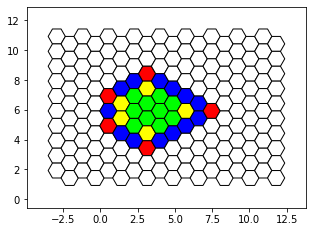

In [ ]:
# demonstrating: Shape.polygon(), Shape.select('interior'), Shape.select('vertices')

COMMANDS = Commands()
BOARD = Board(HEIGHT, WIDTH)

args = {}
def action(args):
  tiles = [Tile(5, 5), Tile(8, 3), Tile(5, 7), Tile(8, 8), Tile(13, 6)]
  poly = Shape.polygon(tiles).draw('blue')
  interior = poly.select('interior').draw('green')
  poly.select('vertices').draw('red')
  interior.select('vertices').draw('yellow')
COMMANDS.add('1', action, args)

executed_board = COMMANDS.execute()[-1]
pu.plot_boards(executed_board)

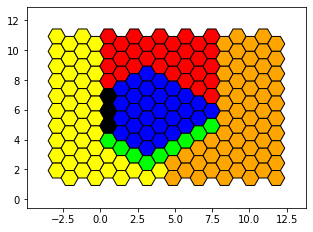

In [ ]:
# demonstrating: Shape.select(), Shape.neighbors(), Shape.extreme(), Shape.filter()

COMMANDS = Commands()
BOARD = Board(HEIGHT, WIDTH)

args = {}
def action(args):
  BOARD.filter('column', '<', 10).draw('yellow')
  tiles = [Tile(5, 5), Tile(8, 3), Tile(5, 7), Tile(8, 8), Tile(13, 6)]
  poly = Shape.polygon(tiles).draw('blue')
  poly_int = poly.select('interior').draw('blue')
  S = poly + poly_int
  S.select('above').draw('red')
  S.neighbors('down').draw('green')
  S.extreme('left').draw('black')
  BOARD.filter('color', '==', 'white').draw('orange')
COMMANDS.add('1', action, args)

executed_board = COMMANDS.execute()[-1]
pu.plot_boards(executed_board)

tile [14, 0] is not on board


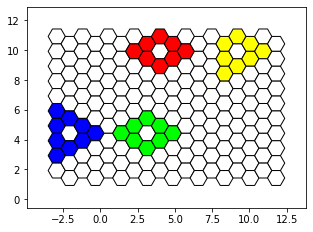

In [ ]:
# demonstrating: Shape.copy_paste() with reference shape

COMMANDS = Commands()
BOARD = Board(HEIGHT, WIDTH)

args = {}
def action(args):
  tiles = [Tile(1,6), Tile(1,9), Tile(4,7)]
  triangle = Shape.polygon(tiles).draw('blue')
  Tile(9,1).draw('red')
  Tile(7,2).draw('red')
  Tile(11,2).draw('red')
  Tile(9,3).draw('red')
  diamond = Shape.polygon(COMMANDS.get_tiles('all')[-4:]).draw('red')
  diamond.copy_paste(shift_direction = 'right', spacing = 2, reference_shape = triangle).draw('green')
  triangle.copy_paste(shift_direction = 'right', spacing = 2, reference_shape = diamond).draw('yellow')
COMMANDS.add('1', action, args)

executed_board = COMMANDS.execute()[-1]
pu.plot_boards(executed_board)



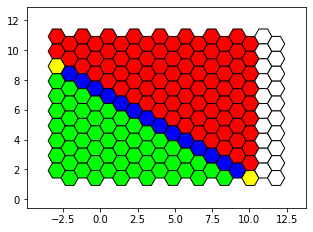

In [ ]:
# demonstrating: Line(), Shape.select()

COMMANDS = Commands()
BOARD = Board(HEIGHT, WIDTH)

args = {}
def action(args):
  L0 = Line(start_tile = Tile(1, 3), direction = 'down_right').draw('blue')
  L0.select('above').draw('red')
  L0.select('below').draw('green')
  L0.select('edges').draw('yellow')
COMMANDS.add('1', action, args)

executed_board = COMMANDS.execute()[-1]
pu.plot_boards(executed_board)

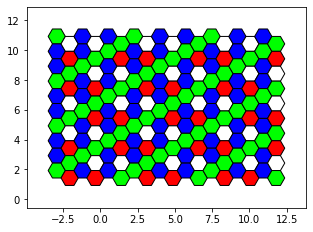

In [ ]:
# demonstrating: Board.filter()

COMMANDS = Commands()
BOARD = Board(HEIGHT, WIDTH)

args = {}
def action(args):
  BOARD.filter('row', 'is', 'even').draw('red')
  BOARD.filter('column', 'is', 'odd').draw('blue')
  BOARD.filter('up_right', 'mod', 0, divisor = 3).draw('green')
COMMANDS.add('1', action, args)

executed_board = COMMANDS.execute()[-1]
pu.plot_boards(executed_board)

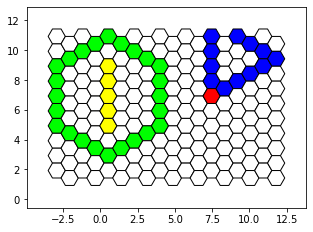

In [ ]:
# demonstrating: Line(), Circle(), Triangle(), Shape.recolor()

COMMANDS = Commands()
BOARD = Board(HEIGHT, WIDTH)

args = {}
def action(args):
  S0 = Line(start_tile = Tile(5,3), end_tile = Tile(5,7)).draw('blue')
  S1 = Circle(Tile(5,5), radius = 4).draw('red')
  (S0+S1).recolor({'red':'green', 'blue':'yellow'})
  Triangle(Tile(13, 5), point = 'right', start_tile_type = 'bottom', side_length = 6).draw('blue')
  Tile(13,5).draw('red')  
COMMANDS.add('1', action, args)

executed_board = COMMANDS.execute()[-1]
pu.plot_boards(executed_board)

tile [19, 2] is not on board


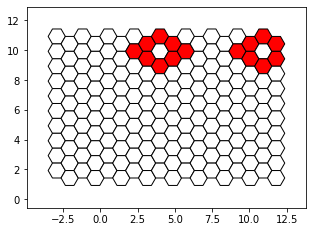

In [ ]:
# demonstrating: COMMANDS.get_tiles()

COMMANDS = Commands()
BOARD = Board(HEIGHT, WIDTH)

args = {}
def action(args):
  Shape.polygon([Tile(9,1), Tile(7,2), Tile(11,2), Tile(9,3)]).draw('red')
COMMANDS.add(command_name = '1', action = action, args = args)

args = {}
def action(args):
  diamond = COMMANDS.get_shapes(command_names = ['1'])[-1]
  diamond.copy_paste(shift_direction = 'right', spacing = 3)
COMMANDS.add(command_name = '2', action = action, args = args)

executed_board = COMMANDS.execute()[-1]
pu.plot_boards(executed_board)

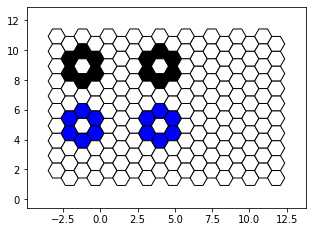

In [ ]:
# demonstrating: COMMANDS.get_action()

COMMANDS = Commands()
BOARD = Board(HEIGHT, WIDTH)

args = {'column':3, 'row':3}
def action(args):
  S0 = Tile(args['column'],args['row']).neighbors()
  S0.draw('black')
COMMANDS.add('1', action, args)

args = {'row':7}
def action(args):
  S0 = Tile(args['column'],args['row']).neighbors()
  S0.draw('blue')
COMMANDS.add('2', action, args)

args = {'column':9}
def action(args):
  COMMANDS.get_action(['1', '2'])(args)
COMMANDS.add('3', action, args)

executed_board = COMMANDS.execute()[-1]
pu.plot_boards(executed_board)

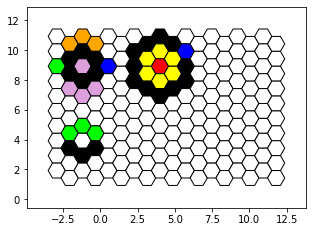

In [ ]:
# demonstrating: Shape.neighbors(), Shape.extreme(), Shape.select()

COMMANDS = Commands()
BOARD = Board(HEIGHT, WIDTH)

args = {}
def action(args):
  S0 = Tile(3,3).neighbors()
  S0.draw('black')
  S0.neighbors('left').draw('green')
  S0.neighbors('right').draw('blue')
  S0.neighbors('up').draw('orange')
  S0.neighbors('down').draw('purple')

  S1 = Tile(3,8).neighbors()
  S1.draw('black')
  S1.extreme('up').draw('green')

  S2 = Tile(9,3).neighbors().neighbors('external')
  S2.draw('black')
  S2.select('interior').draw('red')
  S2.neighbors('internal').draw('yellow')
  S2.extreme('right').extreme('up').draw('blue')

COMMANDS.add('1', action, args)

executed_board = COMMANDS.execute()[-1]
pu.plot_boards(executed_board)

tile [19, 8] is not on board
tile [19, 9] is not on board


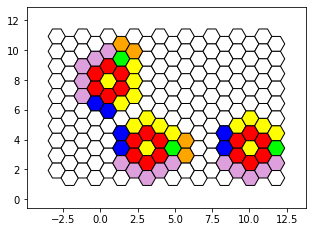

In [ ]:
# demonstrating: Shape.copy_paste(), Shape.reflect()

COMMANDS = Commands()
BOARD = Board(HEIGHT, WIDTH)

args = {}
def action(args):
  S0 = Tile(8,8).neighbors()
  S0.draw('red')
  S1 = S0.neighbors('right')
  S1.draw('green')
  S2 = (S0+S1).neighbors('up')
  S2.draw('yellow')
  S3 = (S0+S1+S2).neighbors('left')
  S3.draw('blue')
  S4 = (S0+S1+S2+S3).neighbors('down')
  S4.draw('purple')
  S5 = (S0+S1+S2+S3+S4).neighbors('right')
  S5.draw('orange')
    # (S0+S1+S2+S3+S4).copy_paste([6,0], color = 'black')
  S6 = S0 + S1 + S2 + S3 + S4 + S5
  S6.copy_paste('right', 2)
  S6.reflect(axis_direction = 'up_right', tile_on_axis = Tile(5,7))
COMMANDS.add('1', action, args)

executed_board = COMMANDS.execute()[-1]
pu.plot_boards(executed_board)

black 0
yellow 1
green 2
red 3
blue 4
purple 5


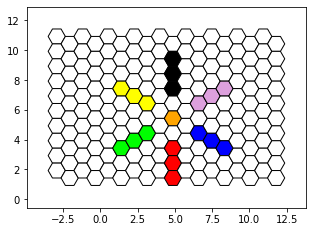

In [ ]:
# demonstrating: Shape.rotate()

COMMANDS = Commands()
BOARD = Board(HEIGHT, WIDTH)

args = {}
def action(args):
  line = Line(start_tile = Tile(10, 4), direction = 'up', length = 3).draw('black')
  center = Tile(10,6).draw('orange')
  for rotation, color in enumerate(COLORS[1:7]):
    print(color, rotation)
    line.rotate(rotation = rotation, center_tile = center).draw(color)
COMMANDS.add('1', action, args)

executed_board = COMMANDS.execute()[-1]
pu.plot_boards(executed_board)

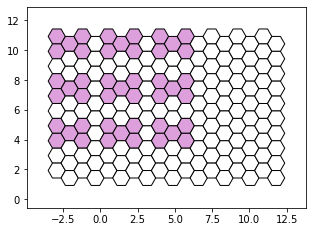

In [ ]:
# demonstrating: Shape.grid()

COMMANDS = Commands()
BOARD = Board(HEIGHT, WIDTH)

args = {}
def action(args):
  S = Shape([Tile(1,1), Tile(1,2), Tile(2,1), Tile(3,1), Tile(3,2)])
  S.draw('purple')
  row = S.grid('right', 1, 2)
  row.grid('down', 1)
COMMANDS.add('1', action, args)

executed_board = COMMANDS.execute()[-1]
pu.plot_boards(executed_board)

# Testing Parsing


# Parsing Utilities

In [ ]:
# reading procedures from json files

f_train = '2022_01_19_hexagon_dataset_extended_public_hard1_train.jsonl'
f_dev = '2022_01_19_hexagon_dataset_extended_public_hard1_dev_abstraction.jsonl'
f_test = '2022_01_19_hexagon_dataset_extended_public_hard1_test.jsonl'

procedures = []
with open(data_dir_name + f_train) as jsonl_file:
    train_procedures = [json.loads(command) for command in jsonl_file]
    for procedure in train_procedures:
      procedure['group'] = 'train'
with open(data_dir_name + f_dev) as jsonl_file:
    dev_procedures = [json.loads(command) for command in jsonl_file]
    for procedure in dev_procedures:
      procedure['group'] = 'dev'
with open(data_dir_name + f_test) as jsonl_file:
    test_procedures = [json.loads(command) for command in jsonl_file]
    for procedure in test_procedures:
      procedure['group'] = 'test'
procedures = train_procedures + dev_procedures + test_procedures

print(len(procedures))
print(procedures[0].keys())

drpr_inds = [d['index'] for d in procedures]

620
dict_keys(['index', 'collection_round', 'category', 'image_index', 'instructor', 'number_of_drawing_steps', 'agreement_tags', 'agreement_scores', 'drawing_procedure', 'group'])


In [ ]:
# read a drawing procedure and show it
def describe(d):
  return f"procedure {d['index']}, image {d['image_index']}, collection round {d['collection_round']}, category {d['category']}, group {d['group']}"

def show(id, plot = True, width = 120):
  d = procedures[id]
  dr_pr = d['drawing_procedure'][1:]
  Bs = [_[2] for _ in dr_pr]
  if plot: 
    print(describe(d))
    for i,txt in enumerate([_[1] for _ in dr_pr]):
      if width == -1:
        wrap_txt = txt
      else:
        wrap_txt = '\n'.join(textwrap.wrap(txt, width = width))
      print(f'{i+1}. {wrap_txt}') 
    print()   
    pu.plot_boards(Bs)
  return(Bs[-1])

# create a parsing template for the drawing procedure
def create_parsing_template(id, width = 120):
  d = procedures[id]
  dr_pr = d['drawing_procedure'][1:]
  print('# ' + describe(d) + '\n')
  print('COMMANDS = Commands()')
  print('BOARD = Board(HEIGHT, WIDTH)\n')
  for i,txt in enumerate([_[1] for _ in dr_pr]):
    print("'''")
    wrap_txt = '\n'.join(textwrap.wrap(txt, width = width))
    print(f'{i+1}. {wrap_txt}')
    print("'''")
    print('args = {}')
    print('def action(args):')
    print('  pass')
    print(f"COMMANDS.add('{str(i+1)}', action, args)\n")
  print('executed_board = COMMANDS.execute()[-1]')
  print('pu.plot_boards([executed_board, ground_truth_board, [(x-y)!=0 for x,y in zip(executed_board, ground_truth_board)]])')

def create_empty_template():
  print('COMMANDS = Commands()')
  print('BOARD = Board(HEIGHT, WIDTH)\n')
  print('args = {}')
  print('def action(args):')
  print('  pass')
  print(f"COMMANDS.add('{str('1')}', action, args)\n")
  print('executed_board = COMMANDS.execute()[-1]')
  print('pu.plot_boards(executed_board)')

# Parsing Example

procedure 93, image P01C03T03, collection round 1, category conditional iteration, group train
1. Starting with the cell in the upper leftmost corner, create a line of 4 cells extending from the lower right edge
orange.
2. From the last cell in the previous step color the next cell in line yellow.
3. Building on the cell in step 2 color 4 cells extending from the upper right side of it orange.
4. Paint 4 cells orange extending straight down from the yellow cell in step 2.
5. Paint the cell directly below the line created in step 4 black.
6. From the bottom edge of the cell in step 5 add 2 orange cells directly beneath it.
7. From the bottom left of the black cell, create a diagonal line going down and to the left of 4 purple cells.
8. From the black cell, create a line of 6 purple cells extending from the top right of the black cell.
9. Extend the line in step 8 by adding 1 blue cell.
10. From the top of the blue cell, color 3 cells purple going straight up.
11. From the bottom right e

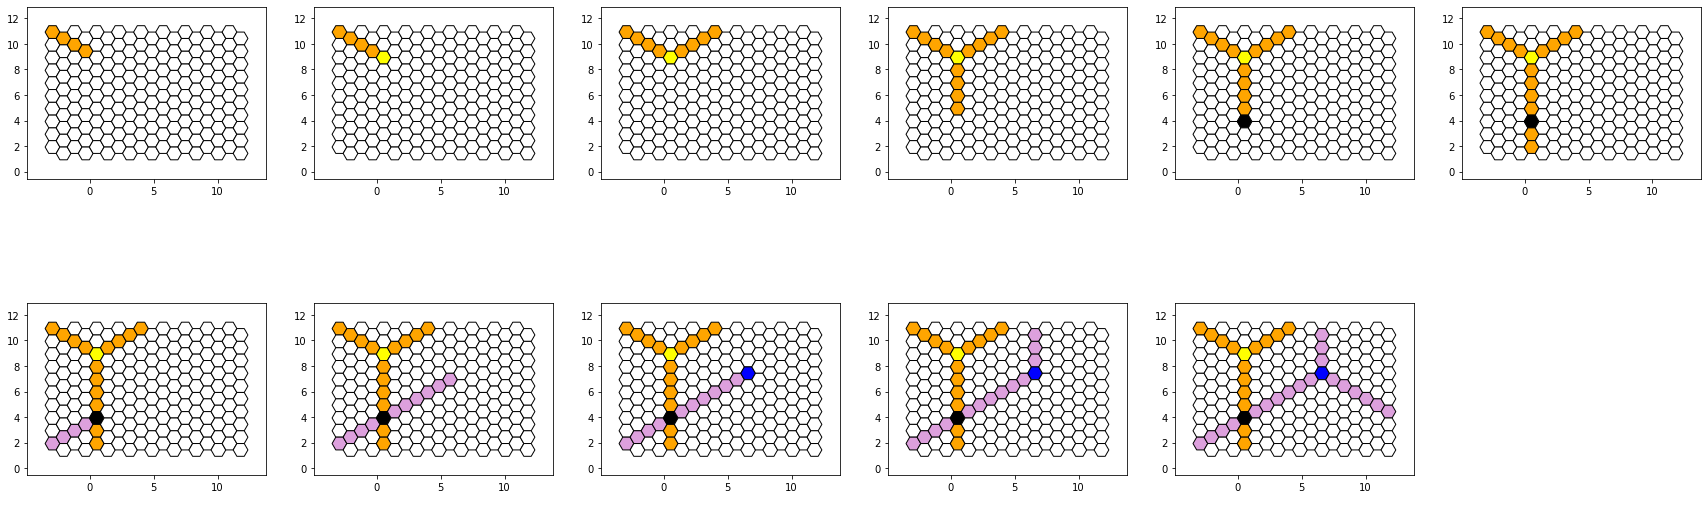

In [ ]:
drpr = 93 # this is the drawing procedure index
internal_id = drpr_inds.index(drpr)
ground_truth_board = show(internal_id, plot = True)

In [ ]:
# create_parsing_template(internal_id)

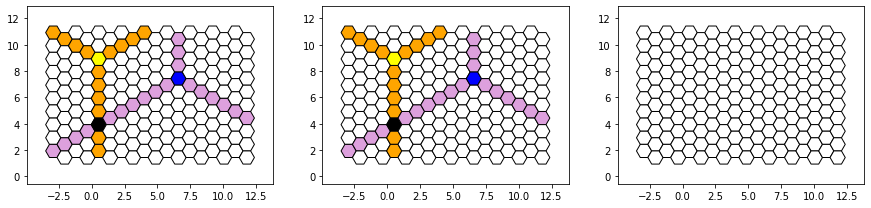

In [ ]:
# procedure 93, image P01C03T03, collection round 1, category conditional iteration, group train

COMMANDS = Commands()
BOARD = Board(HEIGHT, WIDTH)

'''
1. Starting with the cell in the upper leftmost corner, create a line of 4 cells extending from the lower right edge
orange.
'''
args = {}
def action(args):
  Line(start_tile = Tile(1, 1), direction = 'down_right', length = 4).draw('orange')
COMMANDS.add('1', action, args)

'''
2. From the last cell in the previous step color the next cell in line yellow.
'''
args = {}
def action(args):
  last_cell = COMMANDS.get_tiles(['1'])[-1]
  last_cell.neighbor('down_right').draw('yellow')
COMMANDS.add('2', action, args)

'''
3. Building on the cell in step 2 color 4 cells extending from the upper right side of it orange.
'''
args = {}
def action(args):
  step_2_cell = COMMANDS.get_tiles(['2'])[-1]
  Line(start_tile = step_2_cell, direction = 'up_right', length = 4, include_start_tile = False).draw('orange')
COMMANDS.add('3', action, args)

'''
4. Paint 4 cells orange extending straight down from the yellow cell in step 2.
'''
args = {}
def action(args):
  yellow_cell = COMMANDS.get_tiles(['2'])[-1]
  Line(start_tile = yellow_cell, direction = 'down', length = 4, include_start_tile = False).draw('orange')
COMMANDS.add('4', action, args)

'''
5. Paint the cell directly below the line created in step 4 black.
'''
args = {}
def action(args):
  step_4_line = COMMANDS.get_lines(['4'])[-1]
  step_4_line.neighbors('down').draw('black')
COMMANDS.add('5', action, args)

'''
6. From the bottom edge of the cell in step 5 add 2 orange cells directly beneath it.
'''
args = {}
def action(args):
  step_5_cell = COMMANDS.get_tiles(['5'])[-1]
  Line(start_tile = step_5_cell, direction = 'down', length = 2, include_start_tile = False).draw('orange')
COMMANDS.add('6', action, args)

'''
7. From the bottom left of the black cell, create a diagonal line going down and to the left of 4 purple cells.
'''
args = {}
def action(args):
  black_cell = COMMANDS.get_tiles(['5'])[-1]
  Line(start_tile = black_cell, direction = 'down_left', length = 4, include_start_tile = False).draw('purple')
COMMANDS.add('7', action, args)

'''
8. From the black cell, create a line of 6 purple cells extending from the top right of the black cell.
'''
args = {}
def action(args):
  black_cell = COMMANDS.get_tiles(['5'])[-1]
  Line(start_tile = black_cell, direction = 'up_right', length = 6, include_start_tile = False).draw('purple')
COMMANDS.add('8', action, args)

'''
9. Extend the line in step 8 by adding 1 blue cell.
'''
args = {}
def action(args):
  step_8_line = COMMANDS.get_lines(['8'])[-1]
  step_8_line.end_tile.neighbor(step_8_line.direction).draw('blue')
COMMANDS.add('9', action, args)

'''
10. From the top of the blue cell, color 3 cells purple going straight up.
'''
args = {}
def action(args):
  blue_cell = COMMANDS.get_tiles(['9'])[-1]
  Line(start_tile = blue_cell, direction = 'up', length = 3, include_start_tile = False).draw('purple')
COMMANDS.add('10', action, args)

'''
11. From the bottom right edge of the blue cell create a line of 6 purple extending down and to the right.
'''
args = {}
def action(args):
  blue_cell = COMMANDS.get_tiles(['9'])[-1]
  Line(start_tile = blue_cell, direction = 'down_right', length = 6, include_start_tile = False).draw('purple')
COMMANDS.add('11', action, args)

executed_board = COMMANDS.execute()[-1]
pu.plot_boards([executed_board, ground_truth_board, [(x-y)!=0 for x,y in zip(executed_board, ground_truth_board)]])

# Parsing


procedure 276, image P01C06T04, collection round 1, category symmetry, group train
1. Paint the tile black that is fifth from the top in the ninth column from the right.
2. Paint the fifth tile from the top of the far right column red.
3. Paint the four blank tiles that are touching the red tile purple.
4. Moving toward the center, paint the next tile to the left of the purple tiles purple also.
5. Paint all the blank tiles that are touching these purple tiles green, adding one more green tile between the two
leftmost ones to form the point of a sideways V shape.
6. Create a similar shape in blue around the green tiles.
7. Create a symmetrical mirror image of the image formed in steps 2 through 6, to the left of the center black tile.
8. Starting in the tile directly above the black tile paint two diagonal lines to form a V shape between the black tile and
the upper edge of the grid.
9. Inside the V, paint the eleven tiles across the top of the V yellow.
10. Paint the seven blank tiles

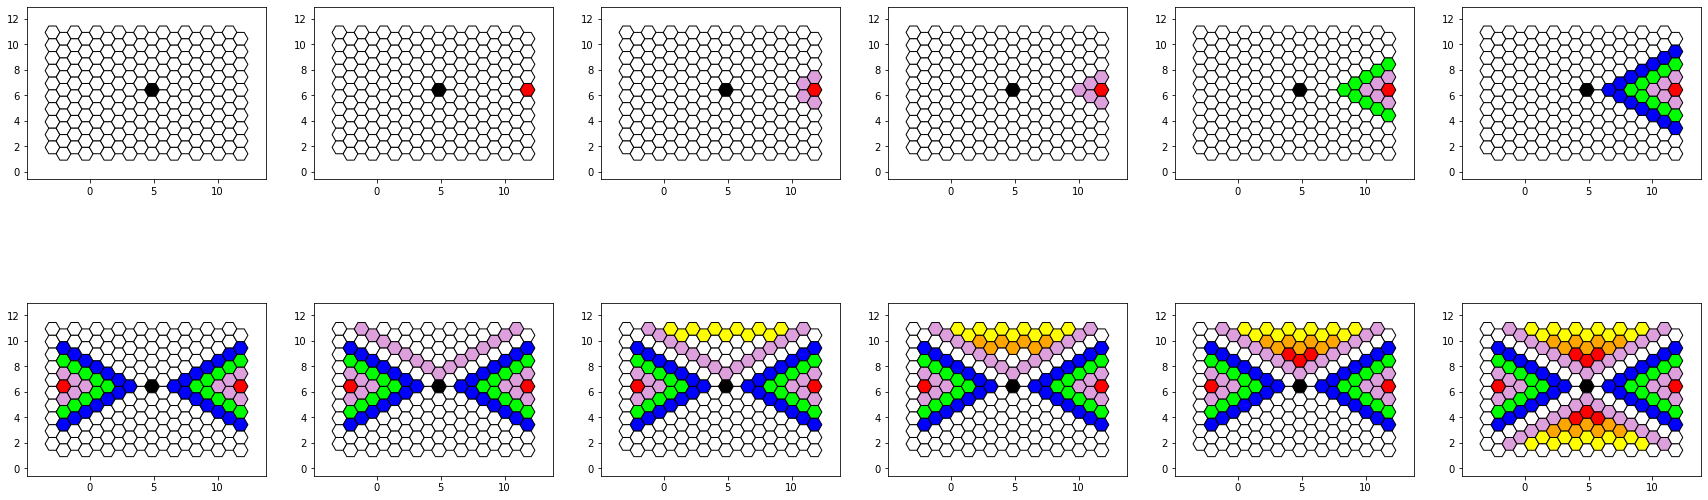

In [ ]:
drpr = 276 # this is the drawing procedure index
internal_id = drpr_inds.index(drpr)
ground_truth_board = show(internal_id, plot = True)

In [ ]:
create_parsing_template(internal_id)

# procedure 276, image P01C06T04, collection round 1, category symmetry, group train

COMMANDS = Commands()
BOARD = Board(HEIGHT, WIDTH)

'''
1. Paint the tile black that is fifth from the top in the ninth column from the right.
'''
args = {}
def action(args):
  pass
COMMANDS.add('1', action, args)

'''
2. Paint the fifth tile from the top of the far right column red.
'''
args = {}
def action(args):
  pass
COMMANDS.add('2', action, args)

'''
3. Paint the four blank tiles that are touching the red tile purple.
'''
args = {}
def action(args):
  pass
COMMANDS.add('3', action, args)

'''
4. Moving toward the center, paint the next tile to the left of the purple tiles purple also.
'''
args = {}
def action(args):
  pass
COMMANDS.add('4', action, args)

'''
5. Paint all the blank tiles that are touching these purple tiles green, adding one more green tile between the two
leftmost ones to form the point of a sideways V shape.
'''
args = {}
def action(args):
  pass
COMMANDS.add('5', action, ar

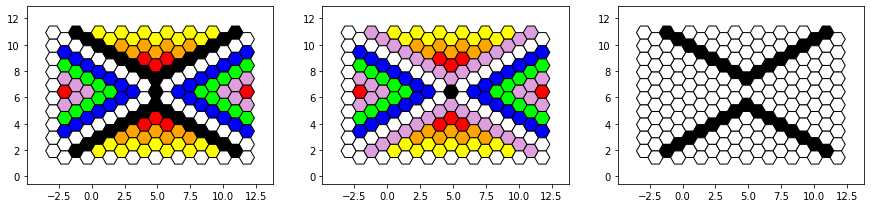

In [ ]:
# procedure 276, image P01C06T04, collection round 1, category symmetry, group train

COMMANDS = Commands()
BOARD = Board(HEIGHT, WIDTH)

'''
1. Paint the tile black that is fifth from the top in the ninth column from the right.
'''
args = {}
def action(args):
  Tile(-9, 5).draw('black')
COMMANDS.add('1', action, args)

'''
2. Paint the fifth tile from the top of the far right column red.
'''
args = {}
def action(args):
  Tile(-1, 5).draw('red')
COMMANDS.add('2', action, args)

'''
3. Paint the four blank tiles that are touching the red tile purple.
'''
args = {}
def action(args):
  red_tile = COMMANDS.get_tiles(['2'])[-1]
  red_tile.neighbors('blank').draw('purple')
COMMANDS.add('3', action, args)

'''
4. Moving toward the center, paint the next tile to the left of the purple tiles purple also.
'''
args = {}
def action(args):
  purple_tiles_shape = Shape(COMMANDS.get_tiles(['3']))
  purple_tiles_shape.neighbors('left').draw('purple')
COMMANDS.add('4', action, args)

'''
5. Paint all the blank tiles that are touching these purple tiles green, adding one more green tile between the two
leftmost ones to form the point of a sideways V shape.
'''
args = {}
def action(args):
  purple_tiles_shape = Shape(COMMANDS.get_tiles(['3', '4']))
  purple_tiles_shape.neighbors('blank').draw('green')
COMMANDS.add('5.1', action, args)

args = {}
def action(args):
  green_tiles_shape = Shape(COMMANDS.get_tiles(['5.1']))
  green_tiles_shape.neighbors('left').draw('green')
COMMANDS.add('5.2', action, args)

'''
6. Create a similar shape in blue around the green tiles.
'''
args = {}
def action(args):
  green_tiles_shape = Shape(BOARD.filter('color', '==', 'green'))
  green_tiles_shape.neighbors('blank').draw('blue')
COMMANDS.add('6.1', action, args)

args = {}
def action(args):
  blue_tiles_shape = Shape(COMMANDS.get_tiles(['6.1']))
  blue_tiles_shape.neighbors('left').draw('blue')
COMMANDS.add('6.2', action, args)

'''
7. Create a symmetrical mirror image of the image formed in steps 2 through 6, to the left of the center black tile.
'''
args = {}
def action(args):
  image_shape = Shape(COMMANDS.get_tiles(['2','3','4','5.1','5.2','6.1','6.2']))
  center_black_tile = COMMANDS.get_tiles(['1'])[-1]
  image_shape.reflect(tile_on_axis = center_black_tile, axis_direction = 'vertical')
COMMANDS.add('7', action, args)

'''
8. Starting in the tile directly above the black tile paint two diagonal lines to form a V shape between the black tile and
the upper edge of the grid.
'''
args = {}
def action(args):
  black_tile = COMMANDS.get_tiles(['1'])[-1]
  tile_directly_above = black_tile.neighbor('up')
  Line(start_tile = tile_directly_above, direction = 'up_left').draw('black')
  Line(start_tile = tile_directly_above, direction = 'up_right').draw('black')
COMMANDS.add('8', action, args)

'''
9. Inside the V, paint the eleven tiles across the top of the V yellow.
'''
args = {}
def action(args):
  V_shape = Shape(COMMANDS.get_tiles(['8']))
  inside_V_shape = V_shape.select('above')
  top_of_V_shape = inside_V_shape.extreme('up')
  top_of_V_shape.draw('yellow')
COMMANDS.add('9', action, args)

'''
10. Paint the seven blank tiles directly touching the yellow ones orange.
'''
args = {}
def action(args):
  yellow_tiles_shape = Shape(COMMANDS.get_tiles(['9']))
  yellow_tiles_shape.neighbors('blank').draw('orange')
COMMANDS.add('10', action, args)

'''
11. Paint the three blank tiles directly touching the orange ones red.
'''
args = {}
def action(args):
  orange_tiles_shape = Shape(COMMANDS.get_tiles(['10']))
  orange_tiles_shape.neighbors('blank').draw('red')
COMMANDS.add('11', action, args)

'''
12. Create a symmetrical mirror image of the figure created in steps 8 through 11, below the center black tile.
'''
args = {}
def action(args):
  image_shape = Shape(COMMANDS.get_tiles(['8','9','10','11']))
  center_black_tile = COMMANDS.get_tiles(['1'])[-1]
  image_shape.reflect(tile_on_axis = center_black_tile, axis_direction = 'horizontal')
COMMANDS.add('12', action, args)

executed_board = COMMANDS.execute()[-1]
pu.plot_boards([executed_board, ground_truth_board, [(x-y)!=0 for x,y in zip(executed_board, ground_truth_board)]])

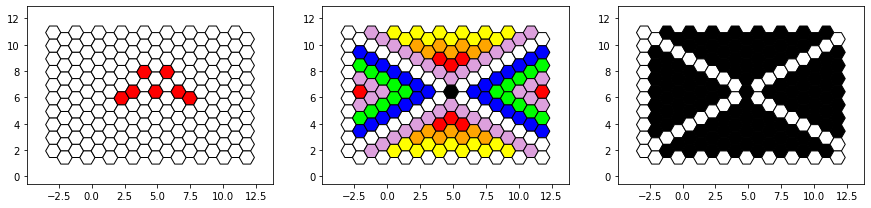

In [ ]:
COMMANDS = Commands()
BOARD = Board(HEIGHT, WIDTH)

args = {}
def action(args):

  # First, create a Tile object for the center of the flower
  center_tile = Tile(column=10, row=5)

  # Then, use the draw method to color the center tile red
  center_tile.draw(color='red')

  # Next, create a list of Tile objects for the petals of the flower
  petal_tiles = [
      Tile(column=9, row=4),
      Tile(column=11, row=4),
      Tile(column=8, row=5),
      Tile(column=12, row=5),
      Tile(column=7, row=6),
      Tile(column=13, row=6),
  ]

  # Finally, use the draw method to color all of the petal tiles red
  for t in petal_tiles:
      t.draw(color='red')

COMMANDS.add('1', action, args)


executed_board = COMMANDS.execute()[-1]
pu.plot_boards([executed_board, ground_truth_board, [(x-y)!=0 for x,y in zip(executed_board, ground_truth_board)]])    

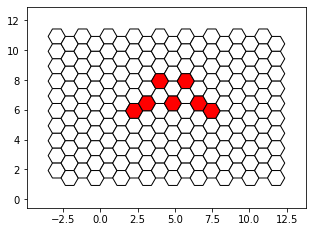

In [ ]:
COMMANDS = Commands()
BOARD = Board(HEIGHT, WIDTH)

args = {}
def action(args):
  # First, create a Tile object for the center of the flower
  center_tile = Tile(column=10, row=5)

  # Then, use the draw method to color the center tile red
  center_tile.draw(color='red')

  # Next, create a list of Tile objects for the petals of the flower
  petal_tiles = [
      Tile(column=9, row=4),
      Tile(column=11, row=4),
      Tile(column=8, row=5),
      Tile(column=12, row=5),
      Tile(column=7, row=6),
      Tile(column=13, row=6),
  ]

  # Finally, use the draw method to color all of the petal tiles red
  for t in petal_tiles:
      t.draw(color='red')
      
COMMANDS.add('1', action, args)

executed_board = COMMANDS.execute()[-1]
pu.plot_boards(executed_board)

# Looking for instructions to give ChatGPT

procedure 24, image P01C02T05, collection round 1, category bounded iteration, group train
1. using the second tile down in the second vertical row (from left) leave that tile white but color all tiles around it
purple. This forms a purple ring.
2. leaving a blank row next over to the right, repeat the pattern, making a ring of 6 purple tiles, continue this pattern
until you have a total of 4 purple rings spaced, leaving a row of vertical tiles between them.



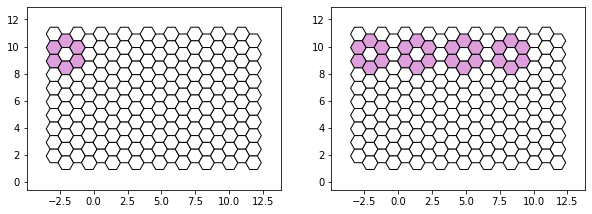

In [ ]:
drpr = 24 # this is the drawing procedure index
internal_id = drpr_inds.index(drpr)
ground_truth_board = show(internal_id, plot = True)


In [ ]:
create_parsing_template(internal_id)

# procedure 24, image P01C02T05, collection round 1, category bounded iteration, group train

COMMANDS = Commands()
BOARD = Board(HEIGHT, WIDTH)

'''
1. using the second tile down in the second vertical row (from left) leave that tile white but color all tiles around it
purple. This forms a purple ring.
'''
args = {}
def action(args):
  pass
COMMANDS.add('1', action, args)

'''
2. leaving a blank row next over to the right, repeat the pattern, making a ring of 6 purple tiles, continue this pattern
until you have a total of 4 purple rings spaced, leaving a row of vertical tiles between them.
'''
args = {}
def action(args):
  pass
COMMANDS.add('2', action, args)

executed_board = COMMANDS.execute()[-1]
pu.plot_boards([executed_board, ground_truth_board, [(x-y)!=0 for x,y in zip(executed_board, ground_truth_board)]])
